The Solr API wrapper allows the users to query the JUUL documents repository, retrieve documents, and process the data efficiently. This wrapper simplifies the process of making HTTP requests to the Solr API, handling pagination through cursor marks, and storing the retrieved data in a structured format.

Import the required libraries

In [ ]:
import requests
import pandas as pd

**Function: query_solr_api**

The query_solr_api function queries the Solr server based on a specified query, retrieves all matching documents, and collects their metadata. It handles pagination using cursor marks to ensure all results are fetched.

Parameters
query (str): The Solr query string to search for specific documents.
format (str): The format of the response from the Solr API (default is 'json').
sort_field (str): The field by which the results should be sorted (default is 'id').
cursor_mark (str): The cursor mark to manage pagination (default is '*').

Returns
documents_list (list): A list of dictionaries, where each dictionary contains the metadata of a retrieved document.

In [ ]:
# Define the query_solr_api function
def query_solr_api(query, format='json', sort_field='id', cursor_mark='*'):
    global documents_list  # Declare documents_list as global
    base_api = f'https://solr.idl.ucsf.edu/solr/ltdl3/query?q={query}&wt={format}'
    documents_list = []  # Initialize the global documents_list

    # while loop to retrieve documents, the loop will run as long as the cursor mark is valid
    while cursor_mark:
        api_final = f"{base_api}&cursorMark={cursor_mark}&sort={sort_field}%20desc"  # constructs the final API url with the current cursor_mark and sorting.
        try:
            response = requests.get(api_final)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f"Error: {e}")
            break

        data = response.json()
        documents = data.get('response', {}).get('docs', [])  # extracts the list of documents from the response.
        documents_list.extend(documents)  # adds all document metadata to documents_list

        # prints information about the current step
        print(f"Retrieved {len(documents)} documents. Total documents collected: {len(documents_list)}")

        # retrieves the next cursor mark for next set of documents. Checks if the cursor_mark hasn't changed to avoid an infinite loop, breaking the loop if it hasn't.
        next_cursor_mark = data.get('nextCursorMark', None)
        if cursor_mark == next_cursor_mark:
            break
        cursor_mark = next_cursor_mark

    # Final output information
    print(f"Total number of documents collected: {len(documents_list)}")
    print(f"Last cursor mark used: {cursor_mark}")

    return documents_list


**Function: save_to_csv**

The save_to_csv function takes the list of document metadata and saves it as a CSV file.

Parameters
documents_list (list): The list of document metadata to be saved.
filename (str): The name of the CSV file to save the data (default is 'documents_metadata.csv').

In [ ]:
# Function to save the documents list to a CSV file
def save_to_csv(documents_list, filename='JUUL_documents_metadata.csv'):
    # Create a DataFrame from the documents list
    df = pd.DataFrame(documents_list)
    # Save DataFrame to CSV
    df.to_csv(filename, index=False)
    print(f"Saved documents metadata to {filename}")

#### The following example demonstrates how to use the API wrapper to query the Solr server for documents related to JUUL Labs Collection, and save the results to a CSV file.

For example, the query input can be query = '(collection:"JUUL labs Collection" AND case:"State of North Carolina" AND type:"email" AND "launch party")'. This retrieves all email metadata related to the launch party.

Another query input could be query = '(collection:"JUUL labs Collection" AND case:"State of North Carolina" AND "age verification")'. This retrieves all documents metadata present in the respository related to age verification.

Another query input could be query = '(collection:"JUUL labs Collection" AND case:"State of North Carolina")'. This retrieves all metadata present in the respository related to the JUUL vs State of North Carolina lawsuit

**Note: The query may take some time to run**


In [ ]:
# Example usage of the function
def main():
    query = '(collection:"JUUL labs Collection" AND case:"State of North Carolina" AND type:"email")' # modify query as required
    documents_list = query_solr_api(query)
    save_to_csv(documents_list, 'juul_documents_metadata.csv')


# Ensures that main function is called only if the script is run directly (not imported as a module)
if __name__ == "__main__":
    main()

Example of output from API Wrapper

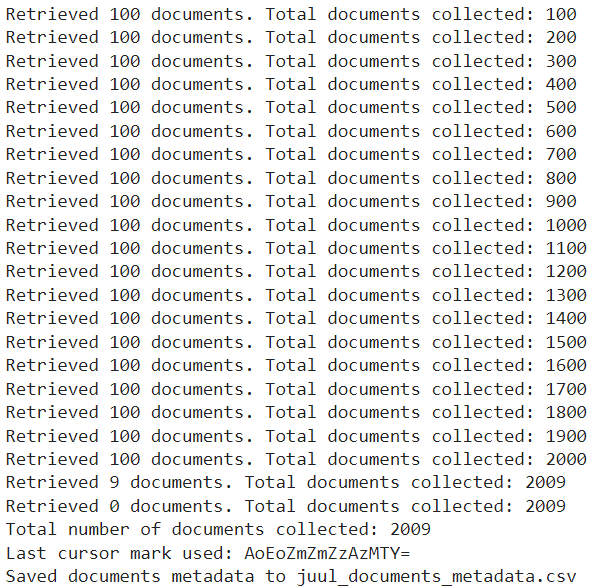


Example of the document metadata stored in a CSV file

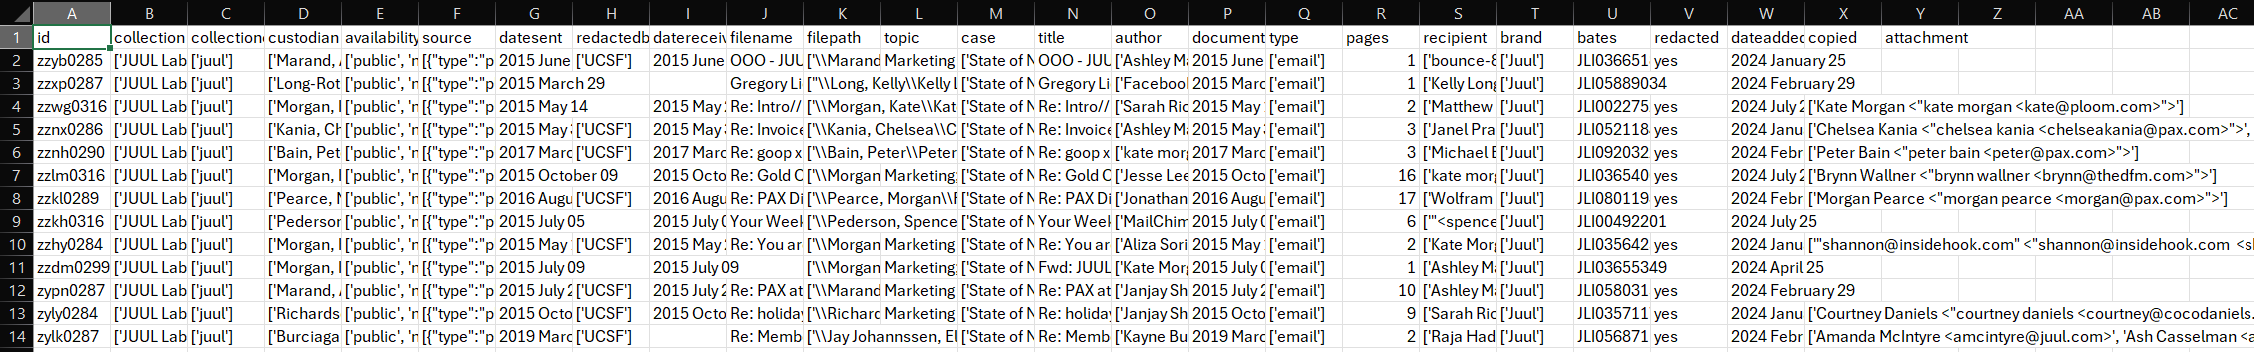


#### Code to retrieve document ids

In [ ]:
# Define the query_solr_api function
def query_solr_api(query, format='json', sort_field='id', cursor_mark='*'):
    global ids_list  # Declare ids_list as global
    base_api = f'https://solr.idl.ucsf.edu/solr/ltdl3/query?q={query}&wt={format}'
    ids_list = []  # Initialize the global ids_list

    # while loop to retrieve documents, the loop will run as long as the cursor mark is valid
    while cursor_mark:
        api_final = f"{base_api}&cursorMark={cursor_mark}&sort={sort_field}%20desc"  # constructs the final API url with the current cursor_mark and sorting.
        try:
            response = requests.get(api_final)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f"Error: {e}")
            break

        data = response.json()
        documents = data.get('response', {}).get('docs', [])  # extracts the list of documents from the response.
        ids_list.extend([doc['id'] for doc in documents if 'id' in doc])  # adds the id of each document to ids_list if it exists.

        # prints information about the current step
        print(f"Retrieved {len(documents)} documents. Total IDs collected: {len(ids_list)}")

        # retrieves the next cursor mark for next set of documents. Checks if the cursor_mark hasn't changed to avoid an infinite loop, breaking the loop if it hasn't.
        next_cursor_mark = data.get('nextCursorMark', None)
        if cursor_mark == next_cursor_mark:
            break
        cursor_mark = next_cursor_mark

    # Final output information
    print(f"Total number of document IDs collected: {len(ids_list)}")
    print(f"Last cursor mark used: {cursor_mark}")

    return ids_list

# Example usage of the function
def main():
    query = '(collection:"JUUL labs Collection" AND case:"State of North Carolina" AND type:"email")'
    ids_list = query_solr_api(query)

    # Save the collected IDs and query input to a CSV file
    output_df = pd.DataFrame({'Document ID': ids_list})
    output_df.to_csv('collected_document_ids.csv', index=False)
    print(f"Collected document IDs saved to 'collected_document_ids.csv'")

# Ensures that main function is called if the script is run directly (not imported as a module)
if __name__ == "__main__":
    main()

Example of documents IDs stored in CSV file

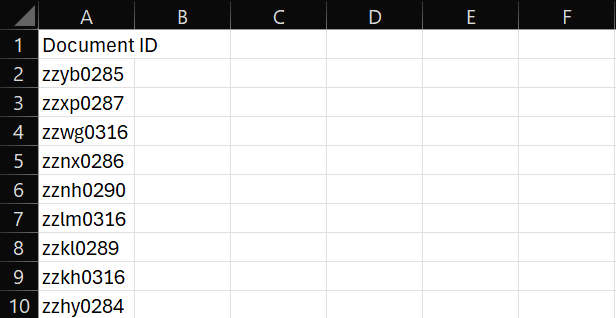

Sanity check: Check for duplicate ids

In [ ]:
#Checks for duplicates of ids in csv and and removes duplicate ids

df_check = pd.read_csv('collected_document_ids.csv') # modify the csv file name as required
number_of_duplicates = df_check.duplicated().sum()
# Remove duplicates if present
if number_of_duplicates > 0:
  df_check.drop_duplicates(inplace=True)
  print("Duplicates removed.")
else:
  print("No duplicates found.")

#df_check.to_csv('collected_document_ids_cleaned.csv', index=False) # save the updated csv if required



The document ids can be used for subsequent analysis such as retrival of OCR texts.